In [1]:
import numpy as np
import torch
from torch import nn

import copy
import time
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
N_FRAMES = 4

In [3]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data, dtype="object")[indices]

        state_data = torch.tensor(np.stack(samples[:, 0])).float()
        act_data = torch.tensor(np.stack(samples[:, 1])).float()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).int()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

In [4]:
class DQN(nn.Module):
    def __init__(self, inp_size):
        
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(inp_size,64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(64,1),
            nn.ReLU())
        
    def forward(self, state_action):
        q_value = self.layer1(state_action)
        q_value = self.layer2(q_value)
        q_value = self.layer3(q_value)
        
        return q_value
        
    def train_on_batch(self, target_model, optimizer, state0, act,
                                 reward, state1, terminal_data, acts, gamma=0.99):
        K=len(acts)
        
        inp = np.concatenate(([state1[0]]*K,acts),axis=1)

        if len(state1)>1:
            for i in state1[1:]:
                inp = np.concatenate((inp,np.concatenate(([i]*K,acts),axis=1)),axis=0)

       
        input = torch.tensor(inp).float() 
        

        q_values = self.forward(input)
        max_q_val = torch.max(q_values.reshape(-1,K),dim=1)[0].detach()
        
        #act = acts[torch.argmax(q_values,dim=1).detach()]
        
        terminal_mod = 1 - terminal_data
        act_qs = reward + terminal_mod*gamma*max_q_val
        
        input = torch.tensor(np.concatenate((state0,act),axis=1)).float() 
        prev_qs = self.forward(input)

        loss = torch.mean((act_qs-prev_qs)**2)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# DQN 

In [10]:
from environment import Environment
from scipy.stats import qmc

In [12]:
X = np.linspace(-3,3,90).reshape(-1,3)
X_dim = 3
y = np.sum(np.sin(X),axis=1)

def f(x):
    s = np.sin(x).shape
    if len(s)>1:
        return np.sum(np.sin(x),axis=1)
    else:
        return [np.sum(np.sin(x))]

l_bounds = [-3,-3,-3]
u_bounds = [3,3,3]

env = Environment(X = X,y = y,l_bounds = l_bounds,u_bounds = u_bounds, func = f, model = 'NN',model_param = {'d':3,'nb_nodes':10,'nb_layers':2,'verbose':False})

state = env.Reset()

In [13]:
X = np.linspace(-3,3,10).reshape(10,-1)
X_dim = 1

y = np.sin(X)

l_bounds = [-3,]
u_bounds = [3,]

env = Environment(X = X,y = y,l_bounds = l_bounds,u_bounds = u_bounds, func = np.sin, model = 'NN',model_param = {'d':1,'nb_nodes':30,'nb_layers':3,'verbose':False})

state = env.Reset()

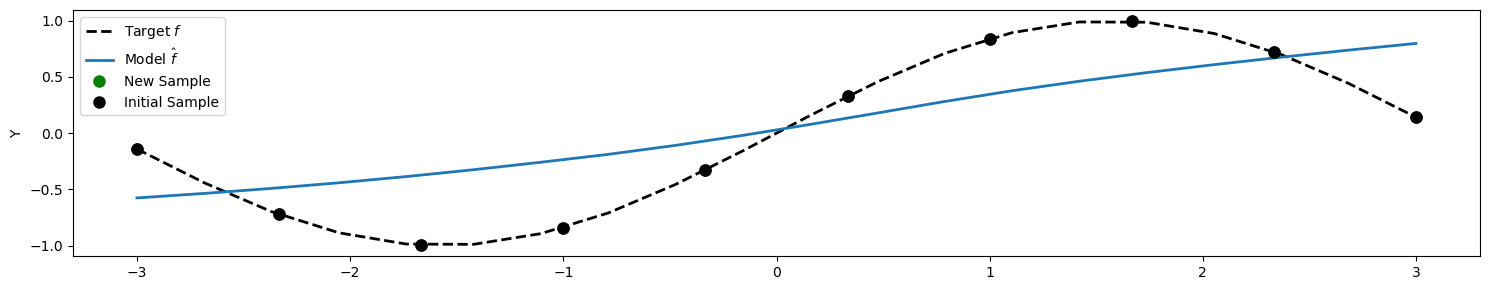

In [14]:
env.toy_Plot(np.linspace(-3,3,20))

In [18]:
n_episodes = 100
max_steps = 50
er_capacity = 15 # 1m in paper

train_batch_size = 32
learning_rate = 2.5e-4
update_freq = 4
print_freq = 5
frame_skip = 3
n_anneal_steps = 1e2 
target_update_delay = 10 
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.1, 1)

In [20]:
import random 

In [22]:
er = ExperienceReplay(er_capacity)
inp_size = len(state)+X_dim
model = DQN(inp_size)

target_model = copy.deepcopy(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-6)
all_rewards = []
global_step = 0

for episode in range(n_episodes):
    obs = env.Reset()
    episode_reward = 0
    step = 0
    while step < max_steps:
        K = 4
        sampler = qmc.LatinHypercube(d=X_dim)
        sample = sampler.random(n=K)
        sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
        acts = np.array(sample_scaled)

        ### Epsilon - greedy ###
        if np.random.rand() < epsilon(global_step):
            act = random.choices(acts,k=1)[0]
           
        else:   
            input = torch.tensor(np.concatenate(([obs]*K,acts),axis=1)).float() 
            q_values = model(input)
           
            act = acts[np.argmax(q_values.detach().numpy())]
        
        next_obs, reward, done, _ = env.Step(act)
        reward = reward
        
        er.add_step([obs, act, reward, next_obs, int(done)])
        obs = next_obs
        
        ### Train on a minibatch ###
        
        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            
           
            model.train_on_batch(target_model, optimizer, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data,acts)
        
        ### Update target network ###
        
        if global_step and global_step % target_update_delay == 0:
            target_model = copy.deepcopy(model)
        
        ### Finish the step ###
        
        step += 1
        global_step += 1
        
        if done:
            print(done)
            break

    all_rewards.append(reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))

True
Episode #0 | Step #3 | Epsilon 0.97 | Avg. Reward -0.07
True
True
True
True
True
Episode #5 | Step #12 | Epsilon 0.89 | Avg. Reward -0.01
True
True
True
True
True
Episode #10 | Step #22 | Epsilon 0.80 | Avg. Reward -0.01
True
True
True


KeyboardInterrupt: 

In [ ]:
env.toy_Plot(np.linspace(-3,3,20))

In [ ]:
state = env.Reset()

for step in range(20):
    K = 10
    sampler = qmc.LatinHypercube(d=X_dim)
    sample = sampler.random(n=K)
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    acts = np.array(sample_scaled)

    if np.random.rand() < 0.05:
            act = random.choices(acts,k=1)[0]
           
    else:   
            input = torch.tensor(np.concatenate(([state]*K,acts),axis=1)).float() 
            q_values = model(input)
           
            act = acts[np.argmax(q_values.detach().numpy())]
        
    state, reward, done, _ = env.Step(act)
    
    env.toy_Plot(np.linspace(-3,3,20))

    #if done:
    #    break